In [1]:
import os,sys
import json
import torch

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

In [2]:
# 构建数据集
from torch.utils.data import DataLoader,Subset
from src.dataset import build_global_vocab_and_maxcount, CLEVRMultiLabelByImage
import torchvision.transforms as T


clevr_root = "../CLEVR_v1.0"

# 全局统计：colors/shapes/max_objects（train+val+test）
colors, shapes, max_objects, _ = build_global_vocab_and_maxcount(clevr_root, splits=("train","val"))

print("num_colors:", len(colors), colors)
print("num_shapes:", len(shapes), shapes)
print("max_objects:", max_objects)


train_ds = CLEVRMultiLabelByImage(
    clevr_root=clevr_root,
    split="train",
    colors=colors,
    shapes=shapes,
    max_objects=max_objects,
)

# 取前 N 个样本（最快、可复现）
N = 2000
train_ds_small = Subset(train_ds, list(range(N)))

train_dl = DataLoader(train_ds, batch_size=100, shuffle=True, num_workers=0)

num_colors: 8 ['blue', 'brown', 'cyan', 'gray', 'green', 'purple', 'red', 'yellow']
num_shapes: 3 ['cube', 'cylinder', 'sphere']
max_objects: 10


In [3]:
# 构建模型
from src.model2 import REVAE

revae = REVAE(skip_mode="add")

In [4]:
from src.train2 import TrainConfig, fit
import torch.optim as optim

cfg = TrainConfig(
    epochs=10,
    lr=1e-3,
    beta_kl=1,
    recon_loss="bce_logits",   # 你已确认 images 在 [0,1] bce_logits\mse\l1
    use_amp=False,
    save_best=False,
    ckpt_dir="../checkpoints",
    ckpt_name="revae.pt",
    device="cuda" if torch.cuda.is_available() else "cpu",
)

optimizer = optim.Adam(revae.parameters(), lr=cfg.lr)

# 若你还没做 val_dl，可以先 val_loader=None
result = fit(revae, train_dl, val_loader=None, optimizer=optimizer, cfg = cfg)


d:\github file\REVAE\src\train2.py:105: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(cfg.use_amp and device.type == "cuda"))
d:\github file\REVAE\src\train2.py:117: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(cfg.use_amp and device.type == "cuda")):


[train] epoch 1total=101359.0368 recon=101358.9508 kl=0.0859
[train] epoch 2total=100949.6872 recon=100949.6802 kl=0.0075
[train] epoch 3total=100908.3210 recon=100908.3153 kl=0.0068
[train] epoch 4total=100885.9329 recon=100885.9299 kl=0.0040
[train] epoch 5total=100872.6404 recon=100872.6376 kl=0.0039
[train] epoch 6total=100861.7525 recon=100861.7510 kl=0.0025
[train] epoch 7total=100854.8995 recon=100854.8979 kl=0.0028
[train] epoch 8total=100848.8053 recon=100848.8052 kl=0.0006
[train] epoch 9total=100845.3524 recon=100845.3522 kl=0.0007
[train] epoch 10total=100840.1274 recon=100840.1274 kl=0.0005


In [5]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ckpt_path = "../checkpoints/revae.pt"  # 你的实际路径
revae = REVAE().to(device)

ckpt = torch.load(ckpt_path, map_location=device)

# 如果你保存的是 {"model": state_dict, ...}
if isinstance(ckpt, dict) and "model" in ckpt:
    revae.load_state_dict(ckpt["model"])
else:
    # 如果你保存的就是纯 state_dict
    revae.load_state_dict(ckpt)

revae.eval()
print("Loaded checkpoint from:", ckpt_path)


Loaded checkpoint from: ../checkpoints/revae.pt


C:\Users\cyh\AppData\Local\Temp\ipykernel_20580\2235088514.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location=device)


In [10]:
# 取第 i 张（你可以换 i）
i = 1100
image, color_mh, shape_mh, count_oh, img_fn = train_ds_small[i]

print("file:", img_fn)
print("gt count:", int(count_oh.argmax()))

file: CLEVR_train_001100.png
gt count: 10


In [11]:
with torch.no_grad():
    x = image.unsqueeze(0).to(device)  # (1,3,224,224)

    out = revae(x)
    if isinstance(out, (tuple, list)) and len(out) == 2:
        x_logits, post = out
    else:
        # 如果你 forward 返回 dict
        x_logits= out["x_logits"]

    p = torch.sigmoid(x_logits)
    print("pred mean:", p.mean().item(), "pred max:", p.max().item(), "pred min:", p.min().item())
    print("gt mean:", image.mean().item(), "gt max:", image.max().item(), "gt min:", image.min().item())

    # --- 重建 ---
    recon = torch.sigmoid(x_logits)[0].detach().cpu()  # (3,224,224) in [0,1]

print("recon shape:", recon.shape)  # 应该是 (3,224,224)
print("recon channel means:", [recon[c].mean().item() for c in range(3)])
print("recon channel stds :", [recon[c].std().item()  for c in range(3)])

print("R-G abs mean:", (recon[0]-recon[1]).abs().mean().item())
print("R-B abs mean:", (recon[0]-recon[2]).abs().mean().item())
print("G-B abs mean:", (recon[1]-recon[2]).abs().mean().item())


pred mean: 0.4499411880970001 pred max: 0.8761011362075806 pred min: 0.0197380930185318
gt mean: 0.4489869475364685 gt max: 0.9843137264251709 gt min: 0.01568627543747425
recon shape: torch.Size([3, 224, 224])
recon channel means: [0.4615413248538971, 0.4477105140686035, 0.44057193398475647]
recon channel stds : [0.10459185391664505, 0.11653123795986176, 0.11774907261133194]
R-G abs mean: 0.022876864299178123
R-B abs mean: 0.03532140329480171
G-B abs mean: 0.034071147441864014


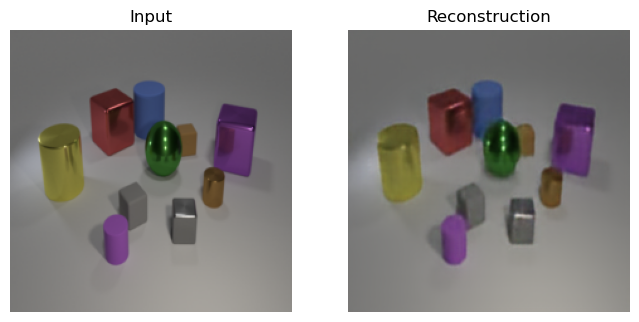

In [12]:
import matplotlib.pyplot as plt

def show_img(t):
    # t: (3,H,W) in [0,1]
    t = t.permute(1,2,0).numpy()
    plt.imshow(t)
    plt.axis("off")

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.title("Input")
show_img(image)          # dataset 给的 image 通常已是 [0,1]

plt.subplot(1,2,2)
plt.title("Reconstruction")
show_img(recon)

plt.show()
